In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import os

# List files in the root directory of your Google Drive
drive_path = '/content/drive/My Drive/scrabble/'
files = os.listdir(drive_path)
files

['hist_player_score_final_data_11-23 with board metrics.xlsx',
 'hist_lastWin_final_data_11-25.xlsx']

In [4]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

df = pd.read_excel(r"/content/drive/My Drive/scrabble/hist_lastWin_final_data_11-25.xlsx")
df.rename(columns={"hist_player_score": "hist_player_performance"}, inplace=True)
df.index = df.game_id
df


,game_id,first,time_control_name,game_end_reason,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds,Bot_nickname,Player_nickname,Bot_turns_count,Player_turns_count,Bot_max_point,Player_max_point,Bot_min_point,Player_min_point,Bot_avg_bingo,Player_avg_bingo,Bot_word_len,Player_word_len,Bot_count_letters_JQXZ,Player_count_letters_JQXZ,Bot_rack_used_rate,Player_rack_used_rate,Bot_win,Player_win,Bot_game,Player_game,Bot_score,Player_score,Bot_rating,Player_rating,created_at,hist_player_performance,Bot_Double_Word,Bot_Triple_Word,Bot_Double_Letter,Bot_Triple_Letter,Player_Double_Word,Player_Triple_Word,Player_Double_Letter,Player_Triple_Letter,hist_player_score_20,last_game_win_flag
game_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
43828,43828,HastyBot,ultrablitz,RESIGNED,CSW21,15,0,RATED,1,61.405180,HastyBot,0188889876,16,16,72,14,0,-10,0.062500,0.000000,4.187500,0.312500,2,0,0.638095,0.178571,1,0,14112,1,472,15,2148,1979.0,2022-09-11 13:06:11,1700.0,4,5,8,4,0,0,1,1,1700.00,0
5765,5765,0927399533,regular,TIME,CSW21,1200,0,RATED,1,1268.252752,BetterBot,0927399533,11,12,92,35,16,-10,0.272727,0.000000,4.090909,2.250000,4,0,0.584416,0.482143,1,0,4847,1,462,141,2012,1447.0,2022-08-09 14:25:28,1700.0,2,3,7,5,4,2,3,0,1700.00,0
40264,40264,BetterBot,regular,TIME,CSW21,1200,0,RATED,1,1262.786704,BetterBot,0927399533,12,12,74,36,8,-10,0.166667,0.000000,4.166667,3.000000,0,2,0.595238,0.467532,1,0,4871,2,356,212,1966,1408.0,2022-08-09 15:26:54,1691.2,7,0,4,6,3,4,5,5,1695.60,0
44376,44376,0927399533,regular,STANDARD,CSW21,1200,0,RATED,1,1209.746654,BetterBot,0927399533,15,16,102,75,8,-10,0.125000,0.062500,3.750000,2.437500,4,0,0.625397,0.396825,1,0,5327,3,535,227,2090,1372.0,2022-08-10 16:28:43,1677.8,6,4,9,5,4,3,9,0,1688.90,0
32633,32633,BetterBot,regular,STANDARD,CSW21,1200,0,RATED,1,1231.166683,BetterBot,0927399533,15,16,85,85,6,-10,0.066667,0.117647,3.400000,2.823529,3,1,0.520952,0.519048,0,1,5336,4,383,391,2114,1367.0,2022-08-10 16:49:00,1676.8,7,1,6,5,6,5,4,2,1688.40,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7264,7264,zuzu,regular,STANDARD,CSW21,1200,0,RATED,1,683.258274,HastyBot,zuzu,13,14,77,78,10,0,0.076923,0.066667,3.846154,3.200000,3,1,0.549451,0.538462,1,0,15306,7,414,327,2231,1855.0,2022-09-13 09:23:17,1750.7,5,2,5,4,5,5,4,1,1725.35,0
66022,66022,zyzzyva,regular,STANDARD,NWL20,1380,0,RATED,1,626.274697,STEEBot,zyzzyva,13,13,78,66,0,0,0.142857,0.076923,3.285714,3.846154,3,1,0.649351,0.595238,1,0,573,1,393,357,1859,1641.0,2022-07-28 18:47:59,1700.0,5,1,5,2,6,3,4,1,1700.00,0
2581,2581,STEEBot,regular,STANDARD,NWL20,1380,0,RATED,1,775.765387,STEEBot,zyzzyva,12,11,70,76,13,17,0.076923,0.181818,3.923077,4.000000,3,1,0.642857,0.571429,0,1,579,2,358,438,1863,1637.0,2022-07-28 18:58:36,1675.9,5,2,6,5,3,4,6,5,1687.95,0


In [5]:

# Drop 'game_id'
df = df.drop('game_id', axis=1)

# Set binary column based on 'first' values
df['first_bot'] = df['first'].isin(["HastyBot", "BetterBot", "STEEBot"]).astype(int)
df = df.drop('first', axis=1)

# One-hot encode categorical columns
categorical_columns = ['time_control_name', 'game_end_reason', 'lexicon', 'rating_mode', 'Bot_nickname']
df = pd.get_dummies(df, columns=categorical_columns)

# Drop 'Player_nickname' and 'created_at'
df = df.drop(['Player_nickname', 'created_at', "Bot_game"], axis=1)

# Move 'Player_rating' to the last column
cols = [col for col in df.columns if col != 'Player_rating'] + ['Player_rating']
df = df[cols]

df

,initial_time_seconds,increment_seconds,max_overtime_minutes,game_duration_seconds,Bot_turns_count,Player_turns_count,Bot_max_point,Player_max_point,Bot_min_point,Player_min_point,Bot_avg_bingo,Player_avg_bingo,Bot_word_len,Player_word_len,Bot_count_letters_JQXZ,Player_count_letters_JQXZ,Bot_rack_used_rate,Player_rack_used_rate,Bot_win,Player_win,Player_game,Bot_score,Player_score,Bot_rating,hist_player_performance,Bot_Double_Word,Bot_Triple_Word,Bot_Double_Letter,Bot_Triple_Letter,Player_Double_Word,Player_Triple_Word,Player_Double_Letter,Player_Triple_Letter,hist_player_score_20,last_game_win_flag,first_bot,time_control_name_blitz,time_control_name_rapid,time_control_name_regular,time_control_name_ultrablitz,game_end_reason_CONSECUTIVE_ZEROES,game_end_reason_RESIGNED,game_end_reason_STANDARD,game_end_reason_TIME,lexicon_CSW21,lexicon_ECWL,lexicon_NSWL20,lexicon_NWL20,rating_mode_CASUAL,rating_mode_RATED,Bot_nickname_BetterBot,Bot_nickname_HastyBot,Bot_nickname_STEEBot,Player_rating
game_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
43828,15,0,1,61.405180,16,16,72,14,0,-10,0.062500,0.000000,4.187500,0.312500,2,0,0.638095,0.178571,1,0,1,472,15,2148,1700.0,4,5,8,4,0,0,1,1,1700.00,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,1979.0
5765,1200,0,1,1268.252752,11,12,92,35,16,-10,0.272727,0.000000,4.090909,2.250000,4,0,0.584416,0.482143,1,0,1,462,141,2012,1700.0,2,3,7,5,4,2,3,0,1700.00,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1447.0
40264,1200,0,1,1262.786704,12,12,74,36,8,-10,0.166667,0.000000,4.166667,3.000000,0,2,0.595238,0.467532,1,0,2,356,212,1966,1691.2,7,0,4,6,3,4,5,5,1695.60,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1408.0
44376,1200,0,1,1209.746654,15,16,102,75,8,-10,0.125000,0.062500,3.750000,2.437500,4,0,0.625397,0.396825,1,0,3,535,227,2090,1677.8,6,4,9,5,4,3,9,0,1688.90,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1372.0
32633,1200,0,1,1231.166683,15,16,85,85,6,-10,0.066667,0.117647,3.400000,2.823529,3,1,0.520952,0.519048,0,1,4,383,391,2114,1676.8,7,1,6,5,6,5,4,2,1688.40,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1367.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7264,1200,0,1,683.258274,13,14,77,78,10,0,0.076923,0.066667,3.846154,3.200000,3,1,0.549451,0.538462,1,0,7,414,327,2231,1750.7,5,2,5,4,5,5,4,1,1725.35,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1855.0
66022,1380,0,1,626.274697,13,13,78,66,0,0,0.142857,0.076923,3.285714,3.846154,3,1,0.649351,0.595238,1,0,1,393,357,1859,1700.0,5,1,5,2,6,3,4,1,1700.00,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,1641.0
2581,1380,0,1,775.765387,12,11,70,76,13,17,0.076923,0.181818,3.923077,4.000000,3,1,0.642857,0.571429,0,1,2,358,438,1863,1675.9,5,2,6,5,3,4,6,5,1687.95,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,1637.0


In [6]:
##Test Train split
train = df[df["Player_rating"].isnull()==False]
test = df[df["Player_rating"].isnull()==True]
df = train

In [7]:
# Assuming df is your DataFrame
X = df.drop('Player_rating', axis=1)  # Features
y = df['Player_rating']  # Target variable

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Fit the model to the data
rf_model.fit(X, y)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to store the results
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the sorted DataFrame
print(feature_importance_df)

                               Feature    Importance
33                hist_player_score_20  4.744403e-01
24             hist_player_performance  2.324773e-01
23                          Bot_rating  5.935382e-02
20                         Player_game  3.002632e-02
3                game_duration_seconds  2.335326e-02
22                        Player_score  2.323645e-02
0                 initial_time_seconds  2.283272e-02
17               Player_rack_used_rate  1.408048e-02
49                   rating_mode_RATED  1.317139e-02
48                  rating_mode_CASUAL  1.243920e-02
13                     Player_word_len  6.955854e-03
21                           Bot_score  5.914291e-03
9                     Player_min_point  5.608437e-03
7                     Player_max_point  5.436971e-03
2                 max_overtime_minutes  4.800324e-03
16                  Bot_rack_used_rate  4.087100e-03
44                       lexicon_CSW21  3.976461e-03
51               Bot_nickname_HastyBot  3.8949

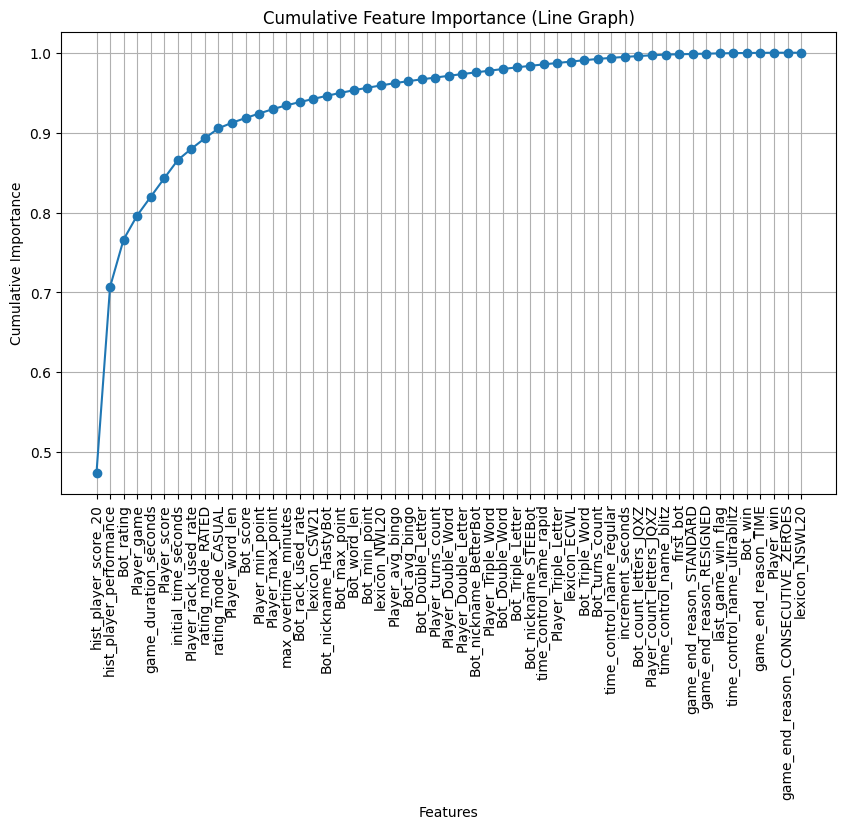

In [8]:
##Plotting to see where to make the cutoff for variable importance
feature_importance_df['Cumulative Importance'] = feature_importance_df['Importance'].cumsum()

# Plot cumulative importance
plt.figure(figsize=(10, 6))
plt.plot(feature_importance_df['Feature'], feature_importance_df['Cumulative Importance'], marker='o', linestyle='-')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance (Line Graph)')
plt.grid(True)
plt.show()

In [ ]:
##initial time seconds is the last variable we would want to include
##We set the threshold to be greater than 2.283272e-02 then

In [9]:
##Making sure no overfitting
selected_features = feature_importance_df[feature_importance_df['Importance'] > 2.283270e-02]

# Sort the DataFrame by importance in descending order
selected_features = selected_features.sort_values(by='Importance', ascending=False)

# Print the sorted DataFrame
selected_features

,Feature,Importance,Cumulative Importance
33,hist_player_score_20,0.474440,0.474440
24,hist_player_performance,0.232477,0.706918
23,Bot_rating,0.059354,0.766271
20,Player_game,0.030026,0.796298
3,game_duration_seconds,0.023353,0.819651
22,Player_score,0.023236,0.842887
0,initial_time_seconds,0.022833,0.865720


In [10]:
# Assuming df is your original DataFrame
selected_feature_names = selected_features['Feature'].tolist()

# Select columns with the important features
df_selected = df[selected_feature_names + ['Player_rating']]

# Display the selected DataFrame
df_selected.head()

,hist_player_score_20,hist_player_performance,Bot_rating,Player_game,game_duration_seconds,Player_score,initial_time_seconds,Player_rating
game_id,,,,,,,,
43828,1700.0,1700.0,2148,1,61.405180,15,15,1979.0
5765,1700.0,1700.0,2012,1,1268.252752,141,1200,1447.0
40264,1695.6,1691.2,1966,2,1262.786704,212,1200,1408.0
44376,1688.9,1677.8,2090,3,1209.746654,227,1200,1372.0
32633,1688.4,1676.8,2114,4,1231.166683,391,1200,1367.0


In [ ]:
######## You do not need to run this

In [ ]:
##Cross Val with normalization

# Assuming df_selected is your DataFrame
X = df_selected.drop('Player_rating', axis=1)
y = df_selected['Player_rating']

# Create a pipeline with a RandomForestRegressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor())
])

# Define parameter grid for grid search
param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 8, 15, 20],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

# Define RMSE as the scoring metric for GridSearchCV
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(np.mean((y_true - y_pred)**2)))

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring=rmse_scorer, n_jobs=-1)

# Fit the model
grid_search.fit(X, y)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_
print("Best Model:", best_model)

# Get cross-validation scores
print("Running cross-validation. This may take some time...")
kf = KFold(n_splits=10, shuffle=True, random_state=42)  # Specify the same number of splits as the GridSearchCV
fold = 1
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    fold_rmse = np.sqrt(np.mean((y_test - y_pred)**2))
    print(f"Fold {fold}: RMSE = {fold_rmse}")
    fold += 1


Best Parameters: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 50}
Best Model: Pipeline(steps=[('scaler', StandardScaler()),
                ('rf', RandomForestRegressor(n_estimators=50))])
Running cross-validation. This may take some time...
Fold 1: RMSE = 84.06753627545838
Fold 2: RMSE = 84.44824112955239
Fold 3: RMSE = 85.95891670120301
Fold 4: RMSE = 83.71456544618553
Fold 5: RMSE = 82.22665332120404
Fold 6: RMSE = 83.49603290890825
Fold 7: RMSE = 85.45825872116771
Fold 8: RMSE = 84.60577865154295
Fold 9: RMSE = 84.81059696984377
Fold 10: RMSE = 83.84412413327637


In [ ]:
######## If you can run this

In [11]:
##Cross Val without normalization

# Assuming df_selected is your DataFrame
X = df_selected.drop('Player_rating', axis=1)
y = df_selected['Player_rating']

# Create a pipeline with a RandomForestRegressor
pipeline = Pipeline([
    ('rf', RandomForestRegressor())
])

# Define parameter grid for grid search
param_grid = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 8],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}

# Define RMSE as the scoring metric for GridSearchCV
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(np.mean((y_true - y_pred)**2)))

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring=rmse_scorer, n_jobs=-1)

# Fit the model
grid_search.fit(X, y)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_
print("Best Model:", best_model)

# Get cross-validation scores
print("Running cross-validation. This may take some time...")
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Specify the same number of splits as the GridSearchCV
fold = 1
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    fold_rmse = np.sqrt(np.mean((y_test - y_pred)**2))
    print(f"Fold {fold}: RMSE = {fold_rmse}")
    fold += 1


Best Parameters: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 50}
Best Model: Pipeline(steps=[('rf',
                 RandomForestRegressor(min_samples_split=5, n_estimators=50))])
Running cross-validation. This may take some time...
Fold 1: RMSE = 84.18860892599052
Fold 2: RMSE = 85.23214445413932
Fold 3: RMSE = 80.59849440806089
Fold 4: RMSE = 83.45116935295859
Fold 5: RMSE = 82.60294119117667


In [ ]:
#########

In [12]:
##Refitting the Model with the optimal parameters
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming df_selected is your DataFrame
X = df_selected.drop('Player_rating', axis=1)
y = df_selected['Player_rating']

# Create a pipeline with a RandomForestRegressor
pipeline = Pipeline([
    ('rf', RandomForestRegressor())
])

# Define parameter grid for grid search
param_grid = {
    'rf__n_estimators': [50],
    'rf__max_depth': [None],
    'rf__min_samples_split': [5],
    'rf__min_samples_leaf': [1]
}

# Define RMSE as the scoring metric for GridSearchCV
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(np.mean((y_true - y_pred)**2)))

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring=rmse_scorer, n_jobs=-1)

# Fit the model
grid_search.fit(X, y)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_
print("Best Model:", best_model)

# Get cross-validation scores
print("Running cross-validation. This may take some time...")
kf = KFold(n_splits=10, shuffle=True, random_state=42)  # Specify the same number of splits as the GridSearchCV
fold = 1
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    fold_rmse = np.sqrt(np.mean((y_test - y_pred)**2))
    print(f"Fold {fold}: RMSE = {fold_rmse}")
    fold += 1


Best Parameters: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 50}
Best Model: Pipeline(steps=[('rf',
                 RandomForestRegressor(min_samples_split=5, n_estimators=50))])
Running cross-validation. This may take some time...
Fold 1: RMSE = 83.29154301177377
Fold 2: RMSE = 82.75993739906083
Fold 3: RMSE = 86.57077600458454
Fold 4: RMSE = 81.30176006255721
Fold 5: RMSE = 79.70591173413335
Fold 6: RMSE = 80.97372425049791
Fold 7: RMSE = 83.18026067135636
Fold 8: RMSE = 82.48250259268697
Fold 9: RMSE = 83.04830172402833
Fold 10: RMSE = 80.57825057891719


In [13]:
test_df_selected = test[selected_feature_names + ['Player_rating']]

# Display the selected DataFrame
test_df_selected.head()
# Assuming df_selected is your DataFrame
test_X = test_df_selected.drop('Player_rating', axis=1)
test_y = test_df_selected['Player_rating']
test_X["Predictions"] = best_model.predict(test_X)
test_X["game_id"] = test_X.index

In [16]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
file_name = f"final_test_results_{timestamp}.csv"



final_test_results = test_X[["game_id", "Predictions"]]
final_test_results.rename(columns={"Predictions": "rating"}, inplace=True)
final_test_results_reset = final_test_results.reset_index(drop=True)
final_test_results_sorted = final_test_results_reset.sort_values(by='game_id', ascending=True)
final_test_results_sorted.to_csv(file_name, index=False)


<ipython-input-16-22e227a15a14>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_test_results.rename(columns={"Predictions": "rating"}, inplace=True)


In [17]:
import os

# List files in the /content directory
files_in_content = os.listdir('/content')
files_in_content


['.config',
 'final_test_results_20231125230357.csv',
 'final_test_results_20231125230410.csv',
 'drive',
 'sample_data']

In [18]:
from google.colab import files

# Download the file to your local machine
files.download('final_test_results_20231125230410.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>